In [2]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['axes.grid'] = False
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
import math
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['axes.grid'] = False
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
import pickle
import numpy as np
import itertools
import pandas as pd
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import InputLayer
from keras.layers import Dense
import neptune.new as neptune
from datetime import datetime
# from keras_visualizer import visualizer
import scipy.stats as stats
import neptune.new.integrations.optuna as optuna_utils
import optuna
import importlib.util
from azure.data.tables import TableServiceClient, UpdateMode
from azure.core.credentials import AzureNamedKeyCredential
import os

In [35]:
with open(f'NIFc1_non_absolute_percentage_of_poc_and_ohlc_avg_across_various_lookbacks_for_all_days.pkl','rb') as file:
    vol_feats = pickle.load(file)/100

In [36]:
vol_feats["AvgDeviation"] = vol_feats.sum(axis=1)

In [37]:
vol_feats["AvgDeviation"] = vol_feats["AvgDeviation"]/11

In [14]:
sum([-0.033974,-0.084789,-0.089838,-0.088859,-0.088197,-0.088678,-0.090747,0.247625,0.318847,0.318847,0.318847])

0.6390839999999999

In [38]:
vol_feats = vol_feats["AvgDeviation"]

In [39]:
vol_feats

2007-01-16    0.021760
2007-01-17    0.020469
2007-01-18    0.005017
2007-01-19    0.005526
2007-01-22    0.004413
                ...   
2022-05-13    0.060637
2022-05-16    0.058098
2022-05-17    0.071343
2022-05-18    0.082904
2022-05-19    0.059847
Name: AvgDeviation, Length: 3783, dtype: float64

In [40]:
pd.DataFrame(vol_feats)

,AvgDeviation
2007-01-16,0.021760
2007-01-17,0.020469
2007-01-18,0.005017
2007-01-19,0.005526
2007-01-22,0.004413
...,...
2022-05-13,0.060637
2022-05-16,0.058098
2022-05-17,0.071343
2022-05-18,0.082904


In [41]:
with open(f'percentage_deviation_avg.pkl', 'wb') as file:
    pickle.dump(pd.DataFrame(vol_feats), file)

In [42]:
vol_feats_df = pd.DataFrame(vol_feats)

<AxesSubplot:>

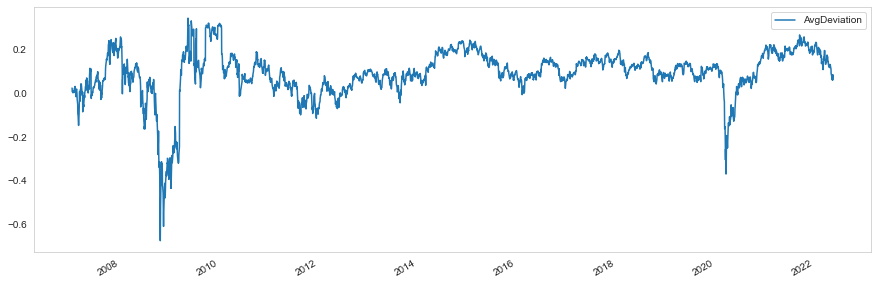

In [44]:
vol_feats_df.plot(y = "AvgDeviation")

In [45]:
np.sign(-3)

-1

In [47]:
ac = "sell" if np.sign(-3) == -1 else "buy" if np.sign(-3) == 1 else "hold"

In [48]:
ac

'sell'

In [49]:
abc = [1,2,3,4,5]

In [50]:
abc.pop(0)

1

In [51]:
abc

[2, 3, 4, 5]

In [52]:
[0]*4

[0, 0, 0, 0]

In [55]:
from keras import backend as K

def custom_activation(x):
    return (K.sigmoid(x) * 2) - 1

x = np.linspace(-10,10,1000)

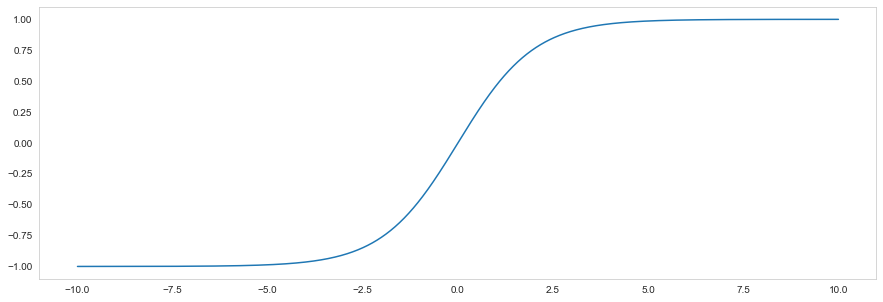

In [56]:
y = custom_activation(x)
plt.plot(x,y)

In [ ]:
def train_q_learning(train, state_lookback, model, alpha, epsilon, gamma, episodes, all_actions, metric, features, plot=True):

    train_data = train.copy()
    returns_vs_episodes = []
    best_episode_return = 0
    weights_best_performing = None

    arr = train_data[[feature['feature'] for feature in features] + [f"{col}_shift{i}" for col in [feature['feature'] for feature in features] for i in range(1, state_lookback)]].values

    for ii in tqdm(range(episodes)):

        #Backtester initialisation
        balance = 10000
        net_worth = balance
        in_position = False
        position_value = 0.0
        price_bought = 0.0
        bet_bought = 0.0
        actions_history = []
        equity_curve = []
        rewards = []
        states = []
        prices = []
        current_q_all_states = []
        next_q_all_states = []

        q = model.predict(arr)
        actions = (-1*q).argsort()

        for i in range(len(train_data)):
            current_adj_close = train_data.iloc[i]["Close"]
            prices.append(current_adj_close)
            states.append(arr[i])
            current_q_all_states.append(q[i])

            # decide action
            if epsilon > 0.1:
                epsilon = epsilon / 1.2

            if np.random.uniform(0, 1) < epsilon:
                action_priority = np.arange(0,len(all_actions))
                np.random.shuffle(action_priority)
            else:
                action_priority = actions[i]

            action = action_priority[0]
            actions_history.append(action)

            if not in_position:
                if action == 1:  # OPEN LONG
                    in_position = True
                    price_bought = current_adj_close
                    bet_bought = balance
                    balance -= bet_bought
                    position_value = bet_bought
                    rewards.append(0)
                else:  # KEEP LOOKING
                    rewards.append(0)
            else:
                market_return = ((current_adj_close - price_bought) / price_bought)
                if action == 1:  # HOLD LONG
                    position_value = bet_bought * (1.0 + market_return)
                    if metric=="absolute":
                        rewards.append(bet_bought*market_return)
                    else:
                        rewards.append(market_return)
                else:  # CLOSE LONG
                    balance += bet_bought * (1.0 + market_return)
                    in_position = False
                    price_bought = 0.0
                    bet_bought = 0.0
                    position_value = 0.0
                    rewards.append(0)

            net_worth = balance + position_value
            equity_curve.append(net_worth)

            try:
                next_q_all_states.append(q[i+1])
            except:
                break

        arr_fit_X = np.empty(shape=(0,len(features)*state_lookback))
        arr_fit_Y = np.empty(shape=(0,len(all_actions)))
        for state, action, reward, cq, nq in zip(states, actions_history, rewards, current_q_all_states, next_q_all_states):
            target = ((1. - alpha) * cq[action]) + alpha * (reward + gamma * np.max(nq))
            cq[action] = target
            arr_fit_X = np.vstack((arr_fit_X,state))
            arr_fit_Y = np.vstack((arr_fit_Y,cq.reshape(-1, len(all_actions))))

        model.fit(arr_fit_X,arr_fit_Y,epochs=30, verbose=0)
        episode_return = equity_curve[-1]/equity_curve[0]-1
        print(f"Episode Number: {ii+1}, Total return of episode: {episode_return}")
        if plot:
            plot_performance(train_data, prices, features, actions_history, equity_curve)

        if episode_return>best_episode_return:
            weights_best_performing = model.get_weights()
            best_episode_return = episode_return

        returns_vs_episodes.append(episode_return)

    return model, returns_vs_episodes, weights_best_performing


In [6]:
from V6 import *


In [26]:
with open("data.pkl","rb") as file:
    data = pickle.load(file) 

train_data = data.iloc[:int(0.8 * len(data)), :]
returns_vs_episodes = []
best_episode_return = 0
weights_best_performing = None
initial_capital = 100
max_units = 5
episodes = 1

for ii in tqdm(range(episodes)):

    #Backtester initialisation
    balance = initial_capital
    net_worth = balance
    # in_position = False
    number_of_units_in_position = 0
    position_value = 0.0
    price_bought = 0.0
    # bet_bought = 0.0
    outcomes_history = []
    equity_curve = []
    rewards = []
    states = []
    benchmark_holding = []
    current_q_all_states = []
    next_q_all_states = []
    benchmark_units = round(initial_capital/train_data.iloc[0]["Close"])
    previous_outcome = 0
    prev_adj_close = train_data.iloc[0]["Close"]
    # q = model.predict(arr)
    # outcomes = (-1*q).argsort()
    list1 = []

    for i in range(1,len(train_data)):    
        current_adj_close = train_data.iloc[i]["Close"]
        benchmark_holding.append(benchmark_units * current_adj_close)

        if current_adj_close - prev_adj_close > 0:
            outcome = 5
        else:
            outcome = -5
        prev_adj_close = current_adj_close
        # outcome = np.random.randint(0,11) - max_units
        outcomes_history.append(outcome)

        balance = balance - (outcome-previous_outcome)*current_adj_close
        position_value = outcome*current_adj_close
        net_worth = balance + position_value
        equity_curve.append(net_worth)
        try:
            if metric=="absolute":
                rewards.append(equity_curve[-1]-equity_curve[-2])
            else:
                rewards.append((equity_curve[-1]-equity_curve[-2])/equity_curve[-2])
        except Exception as e:
            rewards.append(0)
        # try:
        #     next_q_all_states.append(q[i+1])
        # except:
        #     break
        
        dict_vars = {}
        # variables = [current_adj_close, outcome, units_to_buy, number_of_units_in_position, balance, position_value, trade_prices_queue, net_worth]
        dict_vars["current_adj_close"] = current_adj_close
        dict_vars["outcome"] = outcome
        dict_vars["prev_outcome"] = previous_outcome
        dict_vars["balance"] = balance
        dict_vars["position_value"] = position_value
        dict_vars["net_worth"] = net_worth
        list1.append(dict_vars)
        previous_outcome = outcome

    print(pd.DataFrame(list1))
    pd.DataFrame(list1).to_csv("debug.csv")
    # arr_fit_X = np.empty(shape=(0,len(features)*state_lookback))
    # arr_fit_Y = np.empty(shape=(0,len(all_outcomes)))
    # for state, action, reward, cq, nq in zip(states, outcomes_history, rewards, current_q_all_states, next_q_all_states):
    #     target = ((1. - alpha) * cq[action]) + alpha * (reward + gamma * np.max(nq))
    #     cq[action] = target
    #     arr_fit_X = np.vstack((arr_fit_X,state))
    #     arr_fit_Y = np.vstack((arr_fit_Y,cq.reshape(-1, len(all_outcomes))))

    # model.fit(arr_fit_X,arr_fit_Y,epochs=30, verbose=0)
    episode_return = equity_curve[-1]/equity_curve[0]-1
    # print(f"Episode Number: {ii+1}, Total return of episode: {episode_return}")
    # if plot:
    #     plot_performance(train_data, benchmark_holding, features, outcomes_history, equity_curve)

    # if episode_return>best_episode_return:
    #     weights_best_performing = model.get_weights()
    #     best_episode_return = episode_return

    returns_vs_episodes.append(episode_return)


100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

      current_adj_close  outcome  prev_outcome      balance  position_value  \
0              2.295520        5             0    88.522399       11.477601   
1              2.389418        5             5    88.522399       11.947092   
2              2.479426        5             5    88.522399       12.397128   
3              2.564642        5             5    88.522399       12.823212   
4              2.644218        5             5    88.522399       13.221088   
...                 ...      ...           ...          ...             ...   
2898           2.878864        5             5  1003.461885       14.394320   
2899           2.922101        5             5  1003.461885       14.610506   
2900           2.956125        5             5  1003.461885       14.780625   
2901           2.980595        5             5  1003.461885       14.902977   
2902           2.995268        5             5  1003.461885       14.976341   

        net_worth  
0      100.000000  
1      100.

In [70]:
tr = [1,2,3,4,5]

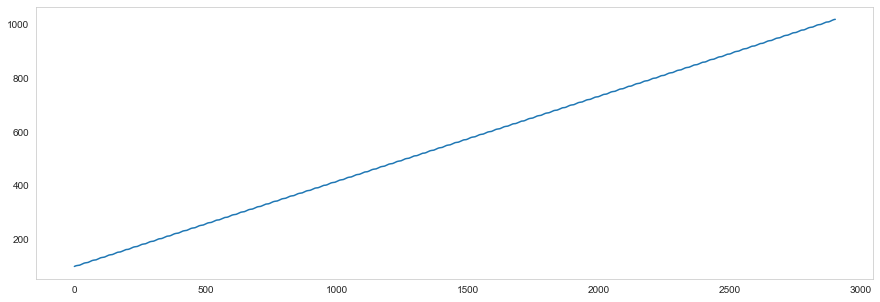

In [27]:
plt.plot(equity_curve)

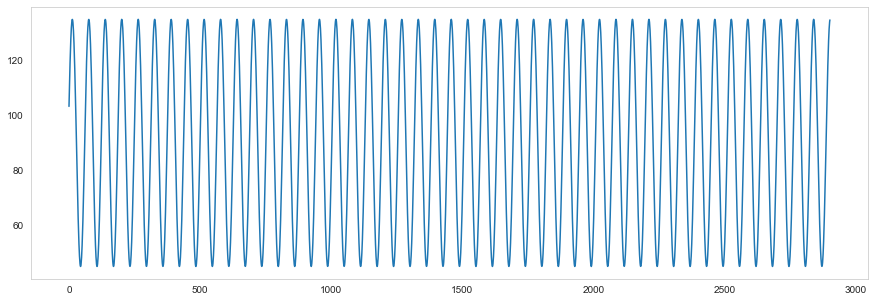

In [23]:
plt.plot(benchmark_holding)

In [71]:
fp = tr.pop(0)

In [72]:
tr

[2, 3, 4, 5]

In [73]:
tr

[2, 3, 4, 5]

In [37]:
with open("q_values_cache.pkl","rb") as file:
    q_values_cache = pickle.load(file)
with open("outcomes_cache.pkl","rb") as file:
    outcomes_cache = pickle.load(file)
with open("rewards_cache.pkl","rb") as file:
    rewards_cache = pickle.load(file)

In [38]:
rewards_cache[0]

[0,
 0.10993346653975308,
 0.10340800939256689,
 0.09755041450360145,
 0.09222815440893391,
 -0.08734255881719015,
 0.09867076320616147,
 0.09229331968657757,
 0.08654632968634048,
 0.08131663767318588,
 -0.06121424954976517,
 0.04959499133906001,
 -0.01591983335940582,
 -0.016296875312371967,
 -0.01663370498116656,
 -0.01692679495711768,
 -0.01717284635942579,
 -0.017368844128897897,
 -0.01751211712939789,
 -0.017600402292874007,
 -0.0176319116877847,
 -0.017605401009511825,
 -0.01752023760278586,
 -0.017376465754131126,
 0.03434973333260209,
 0.032148628937658935,
 0.03005615387149563,
 -0.04210277259835859,
 -0.04215116205586148,
 -0.042077616630965216,
 -0.04188382580982483,
 -0.04157451355635716,
 -0.041157866666063095,
 0.013548638421172833,
 0.025275401052246925,
 -0.03492154011510492,
 -0.011385520747544047,
 -0.010874119930863705,
 0.05196247906144505,
 0.046797053462087845,
 0.042494383717478226,
 0.038923740251069344,
 0.03598498197283131,
 0.03359937406001931,
 0.0317032160

In [39]:
rewards_cache[1]

[0,
 -0.02198669330795056,
 -0.023471257404722976,
 -0.025018565160972586,
 -0.10650866006074151,
 -0.030825515094633257,
 -0.03279281853594355,
 -0.1045273248199415,
 0.07970836546164918,
 -0.037683084890363275,
 -0.03984412960754826,
 -0.0420836225983287,
 -0.2220236439284887,
 -0.0574988459176556,
 -0.06125279912364061,
 -0.06529476188295347,
 -0.06967180723397276,
 -0.07444348121115489,
 -0.07968599421743507,
 -0.08549822692084041,
 -0.09201053157741858,
 -0.1987959306602335,
 -0.12128703632720766,
 -0.13449694538246565,
 -0.15092559716675324,
 -0.1720773255482861,
 -0.6016837948873806,
 -1.4530724617352364,
 3.0756532969080723,
 0.7215703880666791,
 0.3996496637827461,
 0.27155581755844155,
 0.2026318527466462,
 0.15954609318994192,
 0.1300813869135472,
 0.036235044086637885,
 0.033007596834426264,
 0.030170226945334718,
 0.027685150432397422,
 0.02552205867347162,
 0.02365626704798702,
 0.02206728068347714,
 0.020737658940685886,
 0.019652099160975524,
 0.01879668659831635,
 0.01

In [30]:
q_values_cache[0]

array([[-0.0010512 ,  0.00661722,  0.00660539, ..., -0.00061402,
        -0.00689778, -0.00510658],
       [-0.00103477,  0.0065138 ,  0.00650216, ..., -0.00060442,
        -0.00678998, -0.00502677],
       [-0.00087684,  0.00551968,  0.00550981, ..., -0.00051217,
        -0.0057537 , -0.00425959],
       ...,
       [-0.04308941,  0.0385313 , -0.22770402, ...,  0.07566471,
         0.21987067, -0.02605686],
       [-0.04857266,  0.04343451, -0.1144302 , ...,  0.08529323,
         0.24784979, -0.02937265],
       [-0.05231304,  0.04677923, -0.27644587, ...,  0.09186132,
         0.2669357 , -0.03163453]], dtype=float32)

In [ ]:
re

In [33]:
q_values_cache[1]

array([[-7.3255808e-04,  5.7480941e-03,  6.9763977e-03, ...,
         1.8132836e-04, -5.7551377e-03, -4.1589364e-03],
       [-8.8777917e-04,  6.6308142e-03,  7.8806300e-03, ...,
         3.3054072e-02, -6.6842944e-03, -4.8493128e-03],
       [-7.0901815e-04,  5.6142262e-03,  6.8392674e-03, ...,
         3.2395698e-02, -5.6142276e-03, -4.0542381e-03],
       ...,
       [-4.2818073e-02,  3.7438460e-02, -2.2418410e-01, ...,
         7.5474285e-02,  2.1749231e-01, -2.5343275e-02],
       [-4.8298225e-02,  4.2231694e-02, -2.5298852e-01, ...,
         8.5102662e-02,  2.4527444e-01, -2.8643560e-02],
       [-5.2038305e-02,  4.5502964e-02, -2.7264687e-01, ...,
         9.1673814e-02,  2.6423514e-01, -3.0895919e-02]], dtype=float32)

In [35]:
q_values_cache[3]

array([[-9.4342721e-04,  5.4155174e-03,  7.4865608e-03, ...,
         3.9225233e-05, -4.7600870e-03, -4.4202064e-03],
       [-1.1360790e-03,  6.1334823e-03,  8.3003733e-03, ...,
         3.2905981e-02, -5.5560307e-03, -4.9935947e-03],
       [-8.8407879e-04,  5.1943408e-03,  7.2358567e-03, ...,
         3.2256518e-02, -4.5148884e-03, -4.2435676e-03],
       ...,
       [-4.2693369e-02,  3.6334589e-02, -2.2240020e-01, ...,
         7.5491019e-02,  2.1876347e-01, -2.4846470e-02],
       [-4.7915474e-02,  4.1158997e-02, -2.5060621e-01, ...,
         8.5166208e-02,  2.4626932e-01, -2.8264673e-02],
       [-5.1478330e-02,  4.4450536e-02, -2.6985022e-01, ...,
         9.1767259e-02,  2.6503560e-01, -3.0596811e-02]], dtype=float32)

In [31]:
outcomes_cache[1]

array([[ 2,  1,  6, ..., 10,  4,  9],
       [ 2,  1,  6, ..., 10,  4,  9],
       [ 2,  1,  6, ..., 10,  4,  9],
       ...,
       [ 9,  4,  5, ...,  0,  6,  2],
       [ 9,  4,  5, ...,  0,  6,  2],
       [ 9,  4,  5, ...,  0,  6,  2]], dtype=int64)

In [32]:
outcomes_cache[2]

array([[ 2,  1,  6, ...,  4, 10,  9],
       [ 2,  1,  6, ...,  4, 10,  9],
       [ 2,  1,  6, ...,  4, 10,  9],
       ...,
       [ 9,  5,  8, ...,  0,  6,  2],
       [ 9,  5,  8, ...,  0,  6,  2],
       [ 9,  5,  8, ...,  0,  6,  2]], dtype=int64)